In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd

In [33]:
data = pd.read_csv('global.csv')
berlin = data[data['City'] == 'Berlin']
berlin = berlin[berlin['dt'] > '1799-12-01']
# berlin.iloc[1]['dt'] > '1743-12-02'

In [34]:
berlin.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
25174,1800-01-01,-2.289,2.237,Berlin,Germany,52.24N,13.14E
25175,1800-02-01,-2.704,5.605,Berlin,Germany,52.24N,13.14E
25176,1800-03-01,-1.532,5.009,Berlin,Germany,52.24N,13.14E
25177,1800-04-01,13.804,2.169,Berlin,Germany,52.24N,13.14E
25178,1800-05-01,16.429,1.437,Berlin,Germany,52.24N,13.14E


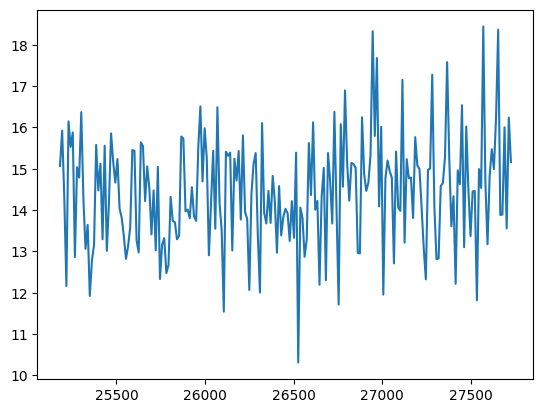

In [48]:
average = berlin['AverageTemperature']
plt.plot(average[8::12])

In [2]:
df = pd.read_csv('nyc_temperature.csv')

In [3]:
df.head()

,date,tmax,tmin,tavg,departure,HDD,CDD,precipitation,new_snow,snow_depth
0,1/1/19,60,40,50.0,13.9,15,0,0.08,0,0
1,2/1/19,41,35,38.0,2.1,27,0,0,0,0
2,3/1/19,45,39,42.0,6.3,23,0,T,0,0
3,4/1/19,47,37,42.0,6.5,23,0,0,0,0
4,5/1/19,47,42,44.5,9.1,20,0,0.45,0,0


In [6]:
temp = df['tavg']
temphigh = df['tmax']
templow = df['tmin']

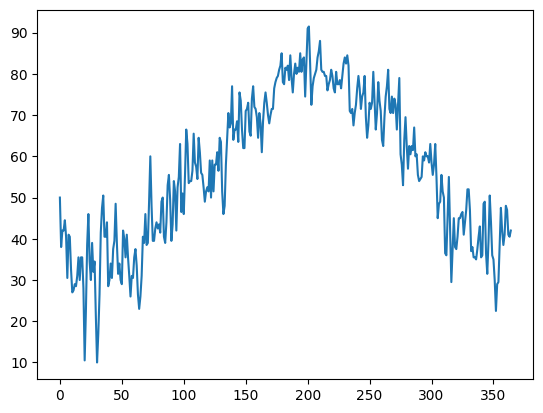

In [9]:
plt.plot(temp)
# plt.plot(temphigh, color = 'red', ls = ":")
# plt.plot(templow, ls = ":")

In [10]:
def sampleACVF(X, h):
    n = len(X)
    x_mean = np.mean(X)
    return 1/n*sum((X[i]-x_mean)*(X[i+abs(h)]-x_mean) for i in range(1,n-abs(h)))
def sampleACF(X, h):
    return sampleACVF(X, h)/sampleACVF(X, 0)

In [27]:
hs = np.arange(-50,50)
raw_acf = [sampleACF(temp,h) for h in hs]

Text(0.5, 1.0, 'ACF dla surowych danych')

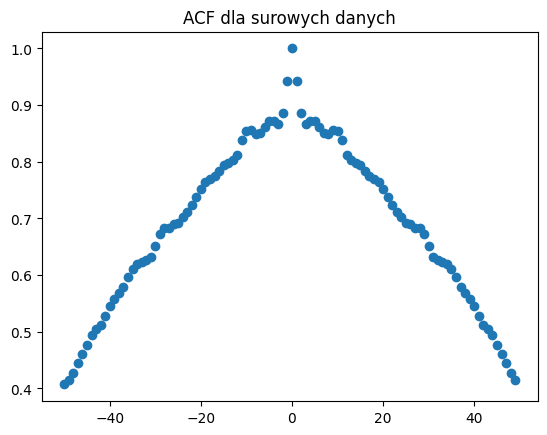

In [14]:
plt.scatter(np.arange(-50,50), raw_acf)
plt.title('ACF dla surowych danych')

In [15]:
import scipy.optimize

def fit_sin(tt, yy):
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

In [18]:
t = np.arange(0, 365)
fit = fit_sin(t, temp) 

In [26]:
1/fit['freq']

353.1511093637461

In [19]:
A, omega, phase, offset = fit['amp'], fit['omega'], fit['phase'], fit['offset']

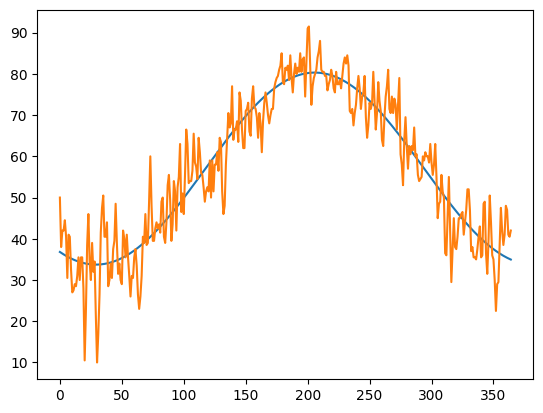

In [21]:
def s(t, A, w, p, c ):
  return A*np.sin(w*t +p) + c
plt.plot(t, s(t, A, omega, phase, offset))
plt.plot(t, temp)

In [23]:
temp_= temp - s(t, A, omega, phase, offset)

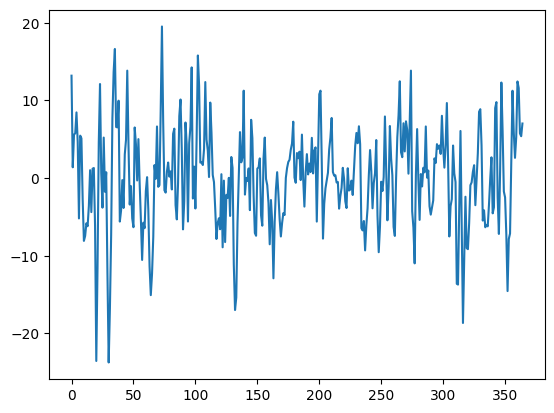

In [24]:
plt.plot(temp_)

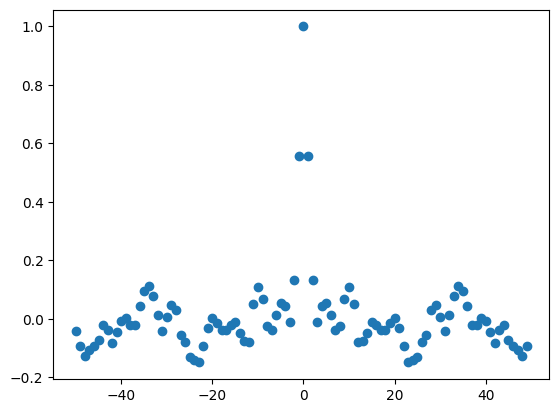

In [29]:
acf2 = [sampleACF(temp_, h) for h in hs]
plt.scatter(hs, acf2)

In [31]:
from statsmodels.tsa.stattools import pacf, pacf_yw

In [33]:
pacf_ywu = pacf(temp, nlags=20, method='yw')  # lub 'ywbiased', 'ols', 'ld'
pacf_ywb = pacf(temp, nlags=20, method='ywadjusted')  # lub 'ywbiased', 'ols', 'ld'
pacf_ols = pacf(temp, nlags=20, method='ols')  # lub 'ywbiased', 'ols', 'ld'
pacf_ld = pacf(temp, nlags=20, method='ld')  # lub 'ywbiased', 'ols', 'ld'

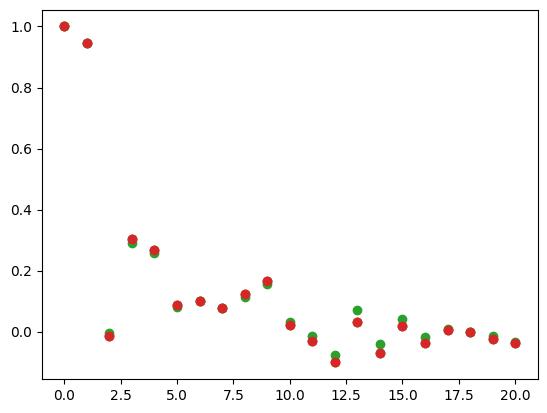

In [38]:
plt.scatter(np.arange(21), pacf_ywu)
plt.scatter(np.arange(21), pacf_ywb)
plt.scatter(np.arange(21), pacf_ols)
plt.scatter(np.arange(21), pacf_ld)
# len(pacf_ywu)

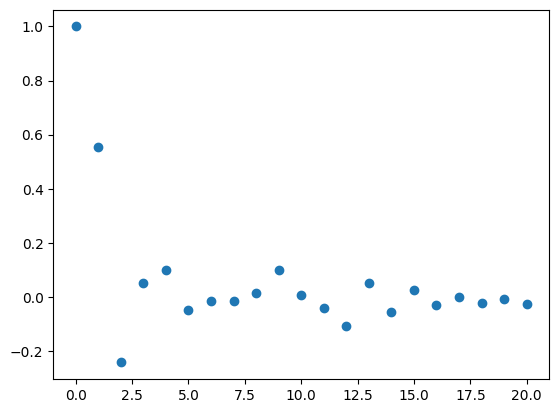

In [39]:
pacf_ = pacf(temp_, nlags=20, method='yw')
plt.scatter(np.arange(21), pacf_)